# Autoencoders 

Autoencoders are neural networks that learn low-dimensional latent representations from which the original data can be reconstructed as well as possible.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

data_with_labels = pd.read_csv("../data/tomato_with_targets.txt", index_col=0)
labels = ['species','position','tissue','root']
data_original = data_with_labels.drop(columns = labels, axis = 1).to_numpy()
scaler = StandardScaler().set_output(transform="default")
data = scaler.fit_transform(data_original)

In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"

In [3]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
import keras

We will apply an autoencoder approach to reduce the dimensionality of the tomato gene expression dataset. For computational efficiency, we will use here only the first 500 genes, so the following call reduces 500-dimensional profiles to two-dimensional profiles.

In [5]:
# Building blocks
def sampling(args, n_components):
    z_mean, z_log_var = args
    epsilon = keras.random.normal(shape=(n_components,), seed=42) # seed=seed_generator
    return z_mean + keras.ops.exp(z_log_var) * epsilon

def build_variational_encoder(inputs, layer_sizes, n_components):
    x = inputs
    for size in layer_sizes:
        x = Dense(size, activation='relu', kernel_initializer='glorot_normal')(x)

    z_mean = Dense(n_components, kernel_initializer='glorot_normal', name='latent_mean')(x)
    z_log_var = Dense(n_components, kernel_initializer='glorot_normal', name='latent_sigma')(x)

    z = Lambda(lambda args: sampling(args, n_components), output_shape=(n_components,))([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    return encoder

def build_encoder(X, layer_sizes, n_components):
    inputs = Input(shape=(X.shape[1],), name='encoder_input')
    x = inputs
    for size in layer_sizes:
        x = Dense(size, activation='relu', kernel_initializer='glorot_normal')(x)
    x = Dense(n_components, activation=None, kernel_initializer='glorot_normal', name='encoder_output')(x)
    encoder = Model(inputs, x, name='encoder')
    return encoder

def build_decoder(X, layer_sizes, n_components):
    latent_inputs = Input(shape=(n_components,), name='decoder_input_sampling')
    x = latent_inputs
    for size in layer_sizes[::-1]:
        x = Dense(size, activation='relu', kernel_initializer='glorot_normal')(x)
    outputs = Dense(X.shape[1], activation=None, kernel_initializer='glorot_normal', name='decoder_output')(x)
    decoder = Model(latent_inputs, outputs, name='decoder')
    return decoder

Model: "ae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 2)              │        75,026 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 500)            │        75,524 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,550 (588.09 KB)

 Trainable params: 150,550 (588.09 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.9068
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9051
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9038
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9019
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.8990
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.8952
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8898
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8831
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8750
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8659
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8562
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8465
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8367
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8264
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8157
Epoch 16/200
1/1 

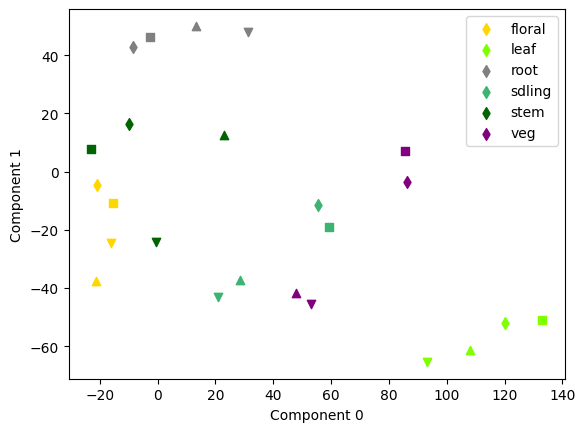

In [6]:
# Simple autoencoder without regularization
tissue_dict = {'floral': 'gold', 'leaf': 'chartreuse', 'root': 'gray', 'sdling': 'mediumseagreen', 'stem': 'darkgreen', 'veg': 'purple'}
species_condition_dict = {'penn.Sun': 's', 'penn.Sh': 'd', 'M82.Sun': '^', 'M82.Sh': 'v'}

def plot_components(data_transformed, j=0, k=1, tissuelegend=True, legendloc="upper right"):
    for i in range(0, data_transformed.shape[0]):
        plt.scatter(data_transformed[i, j], data_transformed[i, k], marker=species_condition_dict['.'.join([data_with_labels.iloc[i]['species'], data_with_labels.iloc[i]['position']])], c=tissue_dict[data_with_labels.iloc[i]['tissue']])
    plt.xlabel("Component {}".format(j)) 
    plt.ylabel("Component {}".format(k))
    if tissuelegend:
        plt.legend(tissue_dict, loc=legendloc)
    else:
        def make_markers(ind):
            return plt.Line2D([], [], color='black', marker=list(species_condition_dict.values())[ind], linestyle='None')
        plt.legend([make_markers(l) for l in range(0, len(species_condition_dict.values()))], species_condition_dict.keys(), loc=legendloc)
    plt.show()


def autoencoder(X, n_components=2):  
    #seed_generator = keras.random.SeedGenerator(42)

    layer_sizes = [128,64,32,16]
    inputs = Input(shape=(X.shape[1],), name='encoder_input')

    encoder = build_encoder(inputs, layer_sizes, n_components)
    decoder = build_decoder(X, layer_sizes, n_components)
    
    ae = Model(inputs, decoder(encoder(inputs)), name='ae')
    print(ae.summary())

    ae.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanSquaredError(), run_eagerly=False) 
    ae.fit(x=X,y=X, epochs=200, verbose=1, batch_size=24)
    
    Y_AE = encoder.predict(X)
    return Y_AE
    

keras.utils.set_random_seed(42) 
Y_AE = autoencoder(data[:,range(500)])
plot_components(Y_AE)


Next, we will try a variational autoencoder. This is an autoencoder that uses regularization during training to ensure that the latent space has certain properties. For that purpose, the loss function is composed of a reconstruction term (for the final layer) and a regularization term (for the latent layer).

In [7]:
# Variational autoencoder
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")

    def train_step(self, x):
        
        self.zero_grad()
        
        z_mean, z_log_var, z = self.encoder(x)
        x_decoded_mean = self.decoder(z)
   
        reconstruction_loss = keras.ops.mean(keras.ops.square(x-x_decoded_mean))
        
        kl_loss = - 0.5 * (1 + z_log_var - keras.ops.square(z_mean) - keras.ops.exp(z_log_var))
        
        kl_loss = keras.ops.mean(keras.ops.sum(kl_loss, axis=1))
        
        total_loss = reconstruction_loss + kl_loss
        
        total_loss.backward()

        trainable_weights = [v for v in self.trainable_weights]
        gradients = [v.value.grad for v in trainable_weights]
        self.optimizer.apply(gradients, trainable_weights)
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result()
        }
    
    def call(self, inputs, *args, **kwargs):
        return self.decoder(self.encoder(inputs)[2])
    
    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker]

def variational_autoencoder(X, n_components=2):  
    keras.utils.set_random_seed(42) 
    #seed_generator = keras.random.SeedGenerator(42)
        
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = keras.random.normal(shape=(n_components,), seed=42) # seed=seed_generator
        return z_mean + keras.ops.exp(z_log_var) * epsilon

    layer_sizes = [128,64,32,16]
    
    #encoder
    inputs = Input(shape=(X.shape[1],), name='encoder_input')
    encoder = build_variational_encoder(inputs, layer_sizes, n_components)  

    #decoder
    decoder = build_decoder(X, layer_sizes, n_components)
        
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam())
    vae.fit(x=X, epochs=200, verbose=1, batch_size=24)
    
    Y_VAE = encoder.predict(X)[0]
    return Y_VAE
    

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.3493 - reconstruction_loss: 0.9072
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.4159 - reconstruction_loss: 0.9062
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1384 - reconstruction_loss: 0.9061
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0401 - reconstruction_loss: 0.9061
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9957 - reconstruction_loss: 0.9060
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9678 - reconstruction_loss: 0.9060
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9513 - reconstruction_loss: 0.9059
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9406 - reconstruction_loss: 0.9059
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9348 - reconstruction_loss: 0.9058
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9302 - reconstruction_loss: 0.9058
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - 

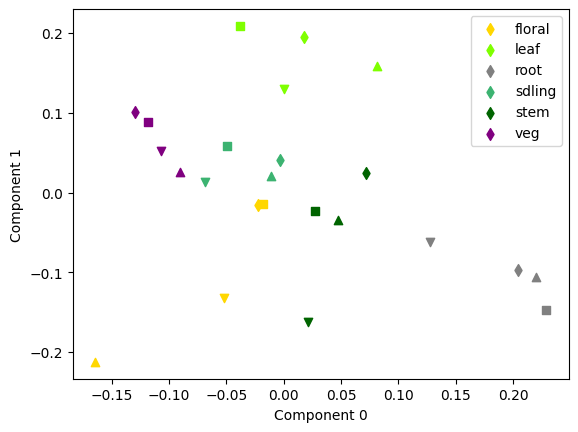

In [8]:
Y_VAE = variational_autoencoder(data[:,range(500)]) 
plot_components(Y_VAE)

### Task:
1. What is the rationale behind using regularization? What can happen without regularization?
2. What is a potential drawback of regularization? What can happen if regularization is too strong? You can play with the weight of the regularization term.